In [1]:
import create_CL
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from itertools import combinations, permutations
from pymatgen.entries.computed_entries import Composition
import seaborn as sns
from matplotlib import ticker
from matplotlib.ticker import FormatStrFormatter, FuncFormatter
from pymatgen.core.periodic_table import Element
from periodic_trends import plotter
import json


/Users/tolstop/anaconda3/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


<h3>Constructing CL among predicted materials</h3>

In [2]:
df = pd.read_csv('new_materials_database.csv')
filtered_Hd_df = df[df['Hd_MEGNET'] < 0.1]
filtered_Hd_df.reset_index(inplace=True)
temp_list = np.array(range(400, 1300, 100))

print(f'Final amount of materials after all filters is {len(df)}')

Final amount of materials after all filters is 35962


In [3]:
two_metal_reactions = create_CL.process_compositions(filtered_Hd_df, function_type='two_metal', exclude_keys=['MP_id'])
print(f'Number of new pairs is {len(two_metal_reactions)}')

material_names = set()
for key in two_metal_reactions.keys():
    material_names.update(key.split('/'))

filtered_pairs_df = filtered_Hd_df[filtered_Hd_df['pretty_formula'].isin(material_names)]
print(f'Final amount of materials forming pairs {len(filtered_pairs_df)}')

/Users/tolstop/Sulfide_aramco_for_paper/05_Expansion_analysis/create_CL.py:351: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['unique_elements'] = df['pretty_formula'].apply(get_unique_elements)


Number of new pairs is 10250
Final amount of materials forming pairs 9328


/Users/tolstop/Sulfide_aramco_for_paper/05_Expansion_analysis/create_CL.py:358: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop(['unique_elements'], axis=1, inplace=True)


In [4]:
def make_json(dictionary, filename):
    json_output = json.dumps(dictionary, indent=4)
    
    with open(f'{filename}.json', 'w') as f:
        f.write(json_output)

make_json(two_metal_reactions, 'BOWSR_two_metal_data')

<h3>Preliminary analysis of materials in these pairs </h3>

In [5]:
def get_metal_type(composition_str):
    metal_type_list = []

    elements = Composition(composition_str).elements
    for element in elements:
        if element.symbol == 'S':
            continue  # Skip 'S'
        # Check the metal type based on the element
        if element.is_transition_metal:
            metal_type = 'Transition'
        elif element.is_alkali:
            metal_type = 'Alkali'
        elif element.is_alkaline:
            metal_type = 'Alkaline'
        elif element.is_post_transition_metal:
            metal_type = 'Post Transition'
        elif element.is_metalloid:
            metal_type = 'Metalloid'
        elif element.is_lanthanoid:
            metal_type = 'Lanthanoid'
        metal_type_list.append(metal_type)
        metal_type_list = sorted(metal_type_list)
        # Add more conditions for other metal types as needed
    return metal_type_list

filtered_pairs_df['Metal_Type'] = filtered_pairs_df['pretty_formula'].apply(get_metal_type)
filtered_pairs_df['Metal_Type_Str'] = filtered_pairs_df['Metal_Type'].apply(lambda row: '/'.join(row))

/var/folders/66/8zx0tncn3gs_xhq4jl2nn7lrrs3zm3/T/ipykernel_94913/2753999772.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_pairs_df['Metal_Type'] = filtered_pairs_df['pretty_formula'].apply(get_metal_type)
/var/folders/66/8zx0tncn3gs_xhq4jl2nn7lrrs3zm3/T/ipykernel_94913/2753999772.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_pairs_df['Metal_Type_Str'] = filtered_pairs_df['Metal_Type'].apply(lambda row: '/'.join(row))


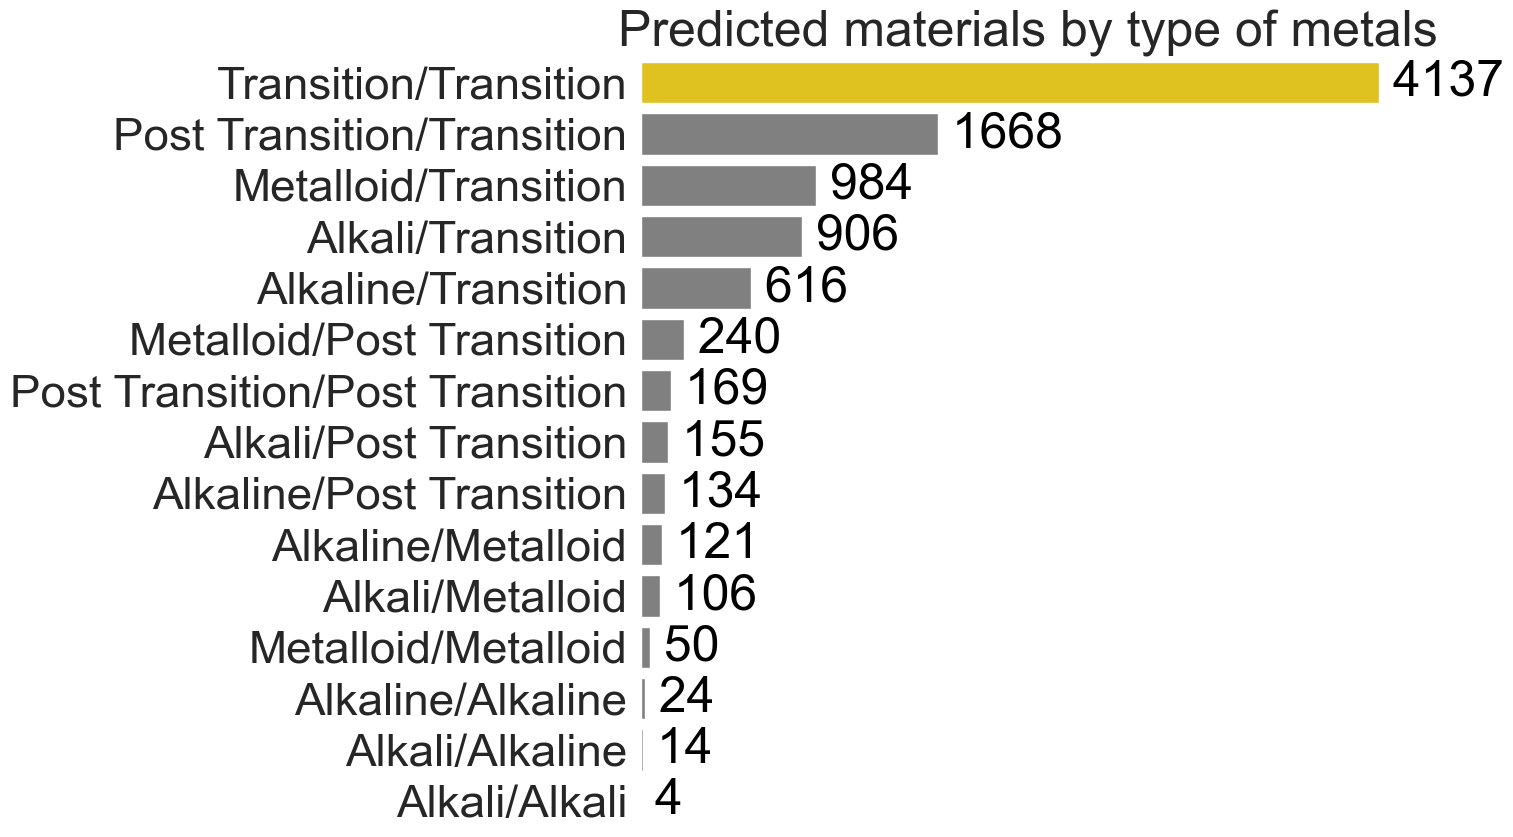

In [6]:
counts = filtered_pairs_df['Metal_Type_Str'].value_counts()
count_df = counts.reset_index()
count_df.columns = ['Metal_Type_Str', 'Count']
count_df = count_df.sort_values(by='Count', ascending=False)

plt.figure(figsize=(10, 10))

sns.set(font_scale=3)
colors = ['grey' if metal_type != 'Transition/Transition' else 'gold' for metal_type in count_df['Metal_Type_Str']]
sns.barplot(x='Count', y='Metal_Type_Str', data=count_df, palette=colors)
for index, value in enumerate(count_df['Count']):
    plt.text(value, index, f' {value}', va='center', ha='left', color='black')
plt.title('Predicted materials by type of metals')
plt.xticks([])
plt.xlabel('')
plt.ylabel('')
plt.box(False)

plt.show()

In [11]:
# Function to extract elements from formula
def extract_elements(formula):
    composition = Composition(formula)
    return composition.elements

filtered_pairs_df['Elements'] = filtered_pairs_df['pretty_formula'].apply(extract_elements)

elements_freq = [element.name for sublist in filtered_pairs_df['Elements'].tolist() for element in sublist]
frequency_table = pd.Series(elements_freq).value_counts().reset_index()
frequency_table.columns = ['Element', 'Frequency']
frequency_dict = frequency_table.set_index('Element')['Frequency'].to_dict()

frequency_dict.pop('S')
df = pd.DataFrame(frequency_dict.items())

df.to_csv('elements_frequency.csv', index=False, header=False)

plotter("elements_frequency.csv",
        cmap="cividis", 
        extended=False,
        periods_remove=[1,7],
        groups_remove=[17,18],
        cbar_height = 350,
        blank_color = 'white',
        under_value = 0
       )

Figure(id='1008', ...)

<h3>Limiting reaction analysis</h3>


for 0, number of viable pairs is 115, mean of dGrlim is 0.24358380099985502
II step    68
I step     47
Name: Limiting_reaction, dtype: int64
for 1, number of viable pairs is 1975, mean of dGrlim is 0.1742068973173928
II step    1129
I step      846
Name: Limiting_reaction, dtype: int64


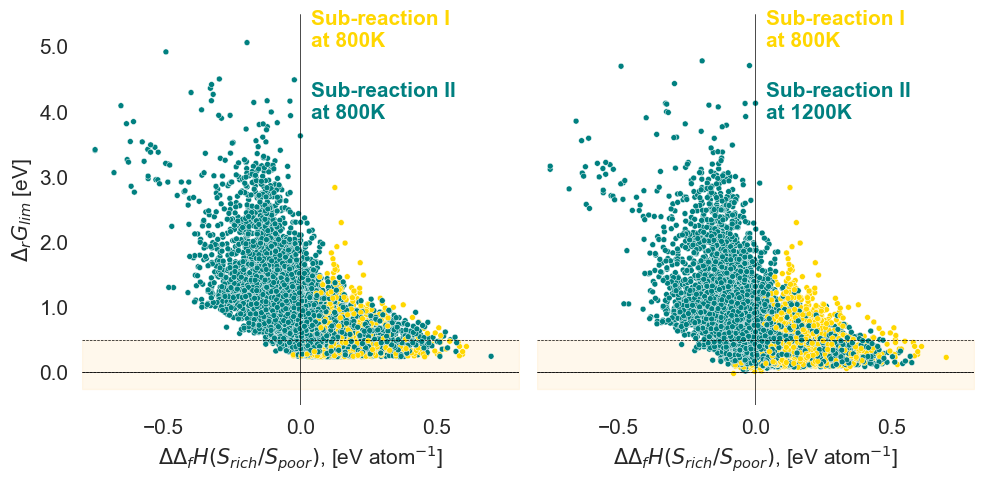

In [12]:
viable_pairs = [[], [], []]
fig, axs = plt.subplots(1,2,figsize=(10,5), sharey=True)
color_I, color_II = 'gold','teal'


for i in range(2):
    data = []

    for material_pair in two_metal_reactions.keys():
        Hf_0_poor = two_metal_reactions[material_pair]['Hf_0K, eV/atom'][0]
        Hf_0_rich = two_metal_reactions[material_pair]['Hf_0K, eV/atom'][1] 
        if i == 0:
            concatenated_list = [two_metal_reactions[material_pair]['Gr_energy, eV'][0][4]] + [two_metal_reactions[material_pair]['Gr_energy, eV'][1][4]]
        elif i == 1:
            concatenated_list = [two_metal_reactions[material_pair]['Gr_energy, eV'][0][4]] + [two_metal_reactions[material_pair]['Gr_energy, eV'][1][8]]
        
    # Find the minimum value and its index
        dGr_lim = max(concatenated_list)
        max_index = concatenated_list.index(dGr_lim)
        threshold = 0.5
        if dGr_lim <= threshold:
            viable_pairs[i].append(material_pair)
            
        # Determine from which list the minimum value comes
        if max_index == 0:
            source_list = "I step"
        else:
            source_list = "II step"

        data.append({'Limiting_reaction': source_list,
                     'Name': material_pair,
                     'delta_H': Hf_0_rich - Hf_0_poor, 
                     'dGr_lim': dGr_lim})
        
    sns.set(style="white")
    df_dGr_lim = pd.DataFrame(data)
    
    ax = plt.subplot(1,2,i+1)
    
    color_palette = {'I step': 'gold', 'II step': 'teal'}

    threshold_value = 0.25
    sns.scatterplot(data=df_dGr_lim, x='delta_H', y='dGr_lim', 
                    hue="Limiting_reaction", size=2, zorder=2, palette=color_palette, alpha=1)
    plt.axhline(0, color='black', linestyle='--', linewidth=0.5)
    xlim, ylim = 0.8, -0.5
    plt.ylim(ylim, 5.5)
    plt.xlim(-xlim, xlim)
    mean_value = df_dGr_lim[df_dGr_lim['dGr_lim'] < threshold_value]['dGr_lim'].mean()
    num_rows = df_dGr_lim[df_dGr_lim['dGr_lim'] < threshold_value].shape[0]
    print(f'for {i}, number of viable pairs is {num_rows}, mean of dGrlim is {mean_value}')
    print( df_dGr_lim[df_dGr_lim['dGr_lim'] < threshold_value]['Limiting_reaction'].value_counts())

    if i == 0:
        plt.text(0.04, 5, 'Sub-reaction I\nat 800K', fontsize=15, color=color_I, fontweight='bold')
        plt.text(0.04, 3.9, 'Sub-reaction II\nat 800K', fontsize=15, color=color_II, fontweight='bold')
        df_800_800 = df_dGr_lim

    elif i == 1:
        plt.text(0.04, 5, 'Sub-reaction I\nat 800K', fontsize=15, color=color_I, fontweight='bold')
        plt.text(0.04, 3.9, 'Sub-reaction II\nat 1200K', fontsize=15, color=color_II, fontweight='bold')       
        df_800_1200 = df_dGr_lim

    plt.axvline(0, color='black', linestyle='-', linewidth=0.5) 
    plt.xlabel(r'${\Delta\Delta}_f\it{H (S _{rich}/S _{poor})}$, [eV atom$^{-1}$]',
              fontsize=15)
    plt.ylabel(r'${\Delta}_r\it{G}_\mathrm{\mathit{lim}}$ [eV]', fontsize=15)
    plt.axhline(0.5, color='black', linestyle='--', linewidth=0.5)
    plt.axhline(0, color='black', linestyle='-', linewidth=0.5)
    ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
    ax.legend().set_visible(False)
    ax.tick_params(which='major', labelsize=15)
    plt.box(False)
    xlim, ylim = 0.8, -0.25
    plt.xlim(-xlim, xlim)
    plt.fill_betweenx([ylim, threshold], xlim, -xlim, color='moccasin', alpha=0.25, zorder=1)

fig.tight_layout()
plt.show()
    

In [13]:
sorted_df = df_800_800.sort_values(by='dGr_lim')
sorted_df.to_csv('limiting_800_800_BOWSR.csv')


sorted_df = df_800_1200.sort_values(by='dGr_lim')
sorted_df.to_csv('limiting_800_1200_BOWSR.csv')

<h3>Correlation map for viable pairs at 800K/1200K</h3>


In [14]:
metals = ["Li", "Be", "Na", "Mg", "Al", "K", "Ca", "Sc", "Ti", "V", "Cr",
                  "Mn", "Fe", "Ni", "Co", "Cu", "Zn", "Ga", "Ge", 'As', "Rb", "Sr", "Y", "Zr", "Nb", "Mo",
                  "Tc", "Ru", "Rh", "Pd", "Ag", "Cd", "In", "Sn", 'Sb', 'Te', "Cs", "Ba", "La", "Hf", "Ta",
                  "W", "Re", "Os", "Ir", "Pt", "Au", "Hg", "Tl", "Pb", "Bi"]                   
                        
def extract_elements_two(formula):
    formula_str = formula.split('/')[0] 
    elements = Composition(formula_str).elements
    elements.remove(Element('S'))
    return elements

num_metals = len(metals)
counts_matrix = np.zeros((num_metals, num_metals))

list_of_elements = [extract_elements_two(formula) for formula in viable_pairs[i]]
for metals_composition in list_of_elements:
    metal1, metal2 = metals_composition

    metal1 = str(metal1)
    metal2 = str(metal2)

    x = metals.index(metal1)
    y = metals.index(metal2)
    counts_matrix[x][y] += 1
    counts_matrix[y][x] += 1


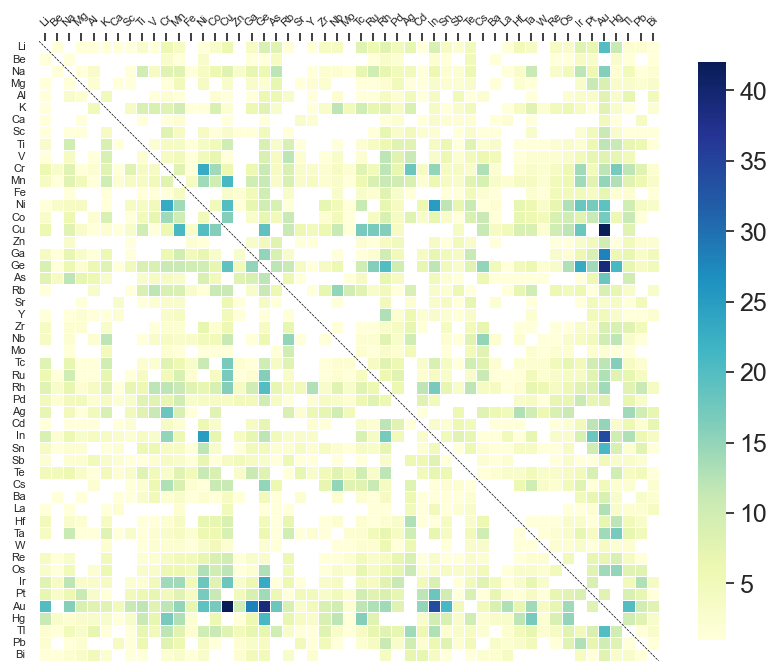

In [15]:
plt.figure(figsize=(10, 10))
sns.set_style('white')
g = sns.heatmap(counts_matrix,
            cmap='YlGnBu', 
            xticklabels=metals, 
            yticklabels=metals,
            mask=(counts_matrix == 0),
            linewidth=.5,
            square=True,
            cbar_kws={'shrink': 0.75},    
           )
plt.axline((0, 0), (1, 1),
           linewidth=0.5, 
           color='black', 
           linestyle='--'
          )
cbar = g.collections[0].colorbar
cbar.ax.tick_params(labelsize=18)
g.set_xticklabels(g.get_xticklabels(), size=8, rotation=45)
g.set_yticklabels(g.get_yticklabels(), size=8)
g.xaxis.tick_top()
plt.show()